## 1. SetUp

In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.0 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=5c89

In [2]:
import os, gc, json, shutil, yaml, warnings, random, math, copy
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import umap.umap_ as umap

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from ultralytics import YOLO


warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3377.84it/s]


In [4]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


In [5]:
# BASE  = Path("/kaggle/input/annotated-rice-panicle-image-from-bangladesh")
# WORK  = Path("/kaggle/working/rice_ssl")
# SPLIT = WORK / "0_yolo_split"
# DATA  = WORK / "data_rice.yaml"
# SSL_W = WORK / "BYOL_ssl_yolov11_backbone.pth"   # save neck/backbone weights only
# WORK.mkdir(parents=True, exist_ok=True)

## 2. Assign a detection Catch

In [6]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]


## 3. Dataset Path

In [7]:
COCO_ROOT     = Path("/kaggle/working/Final-1")  # folder containing train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"
WORK          = Path("/kaggle/working/SSL-BYOL")  # output directory (can rename)
SSL_W         = WORK / "BYOL_ssl_yolov11_backbone.pth"
WORK.mkdir(parents=True, exist_ok=True)

## 4. COCO→YOLO conversion

In [8]:
# Create output directory structure
for split in ["train", "valid", "test"]:
    for sub in ["images", "labels"]:
        (WORK / split / sub).mkdir(parents=True, exist_ok=True)

# Function to convert COCO bbox to YOLO format
def coco2yolo(box, w, h):
    x, y, w_box, h_box = box
    return ((x + w_box/2) / w, (y + h_box/2) / h, w_box / w, h_box / h)

# Convert one split from COCO to YOLO format
def convert(split, img_dir, ann_file, out_dir):
    with open(ann_file, "r") as f:
        coco = json.load(f)

    id2img = {img["id"]: img for img in coco["images"]}
    imgs_o = out_dir / split / "images"
    labs_o = out_dir / split / "labels"

    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        yolo_box = coco2yolo(ann["bbox"], img["width"], img["height"])
        cls = ann["category_id"] - 1  # Class index starts from 0 in YOLO
        label_path = labs_o / f"{Path(img['file_name']).stem}.txt"
        with open(label_path, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yolo_box) + "\n")

    for img in coco["images"]:
        shutil.copy(img_dir / img["file_name"], imgs_o / img["file_name"])

# ----------------------------------------------------------------------------
# 1. Perform Conversion
# ----------------------------------------------------------------------------
convert("train", TRAIN_IMG_DIR, TRAIN_ANN, WORK)
convert("valid", VAL_IMG_DIR,   VAL_ANN,   WORK)
convert("test",  TRAIN_IMG_DIR, TRAIN_ANN, WORK)  # Optional test reuse


## 5. Save the YAML file

In [9]:
import yaml

cats  = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
data_cfg = {
    "path":  str(WORK),
    "train": "train/images",
    "val":   "valid/images",
    "test":  "test/images",
    "nc":    len(names),
    "names": names
}
DATA = WORK / "data_Sunflower.yaml"
(DATA).write_text(yaml.dump(data_cfg))

112

## 6. Set the Two-view function

In [10]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

## 7. BYOL Loss Function and Detection hook

In [11]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

## 8. YOLOv11s model type backbone, optmizer setup, training loop and save the backbone weight

In [12]:
MODEL = "yolo11s.pt"     
SSL_EPOCHS, SSL_BATCH = 50, 64 # EPOCHS and BATCH SIZE
m0 = 0.996

if SSL_W.exists():
    print("BYOL backbone cached – skipping pre-train")
else:
    print("BYOL pre-training (1 epoch, hook-based, YOLOv11) …")

    # full models (we'll read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView([WORK/"train"/"images", WORK/"valid"/"images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # online encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"Epoch {ep+1}/{SSL_EPOCHS} BYOL loss={running/len(dl):.4f}")

    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)

BYOL pre-training (1 epoch, hook-based, YOLOv11) …


Backbone feature dim: 896


BYOL 1/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/50 BYOL loss=1.5687


BYOL 2/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2/50 BYOL loss=1.3939


BYOL 3/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3/50 BYOL loss=1.3303


BYOL 4/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4/50 BYOL loss=1.2476


BYOL 5/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5/50 BYOL loss=1.1922


BYOL 6/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6/50 BYOL loss=1.1168


BYOL 7/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7/50 BYOL loss=1.0932


BYOL 8/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8/50 BYOL loss=1.0588


BYOL 9/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9/50 BYOL loss=1.0367


BYOL 10/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10/50 BYOL loss=1.0067


BYOL 11/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11/50 BYOL loss=0.9797


BYOL 12/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12/50 BYOL loss=0.9539


BYOL 13/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13/50 BYOL loss=0.9267


BYOL 14/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14/50 BYOL loss=0.9280


BYOL 15/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15/50 BYOL loss=0.9192


BYOL 16/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16/50 BYOL loss=0.9027


BYOL 17/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17/50 BYOL loss=0.8924


BYOL 18/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18/50 BYOL loss=0.8607


BYOL 19/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19/50 BYOL loss=0.8596


BYOL 20/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20/50 BYOL loss=0.8603


BYOL 21/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21/50 BYOL loss=0.8537


BYOL 22/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22/50 BYOL loss=0.8739


BYOL 23/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23/50 BYOL loss=0.8449


BYOL 24/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24/50 BYOL loss=0.8537


BYOL 25/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/50 BYOL loss=0.8402


BYOL 26/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26/50 BYOL loss=0.8416


BYOL 27/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27/50 BYOL loss=0.8360


BYOL 28/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28/50 BYOL loss=0.8396


BYOL 29/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29/50 BYOL loss=0.8359


BYOL 30/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30/50 BYOL loss=0.8089


BYOL 31/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31/50 BYOL loss=0.8471


BYOL 32/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 32/50 BYOL loss=0.8226


BYOL 33/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33/50 BYOL loss=0.8156


BYOL 34/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34/50 BYOL loss=0.8090


BYOL 35/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 35/50 BYOL loss=0.8172


BYOL 36/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 36/50 BYOL loss=0.8244


BYOL 37/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37/50 BYOL loss=0.8033


BYOL 38/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38/50 BYOL loss=0.8226


BYOL 39/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39/50 BYOL loss=0.8117


BYOL 40/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 40/50 BYOL loss=0.7979


BYOL 41/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 41/50 BYOL loss=0.7928


BYOL 42/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 42/50 BYOL loss=0.7833


BYOL 43/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 43/50 BYOL loss=0.7938


BYOL 44/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 44/50 BYOL loss=0.8101


BYOL 45/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 45/50 BYOL loss=0.8098


BYOL 46/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 46/50 BYOL loss=0.8029


BYOL 47/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 47/50 BYOL loss=0.7982


BYOL 48/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 48/50 BYOL loss=0.7943


BYOL 49/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 49/50 BYOL loss=0.7850


BYOL 50/50:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 50/50 BYOL loss=0.8001
✓ Saved SSL backbone weights → /kaggle/working/SSL-BYOL/BYOL_ssl_yolov11_backbone.pth


## 9. Feature extraction plot (K-NN, PCA, t-SNE, UMAP)

➤ Loading BYOL feature extractor …
➤ Extracting features …


Extract train:   0%|          | 0/62 [00:00<?, ?it/s]

Extract val:   0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7dcd8c0f3f60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error



BYOL k-NN evaluation …
k-NN accuracy (val): 1.0000


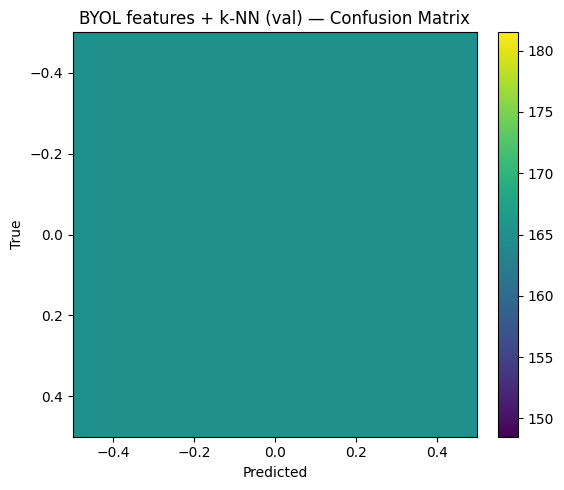

➤ Running PCA …
PCA 2D explained variance: 24.88%


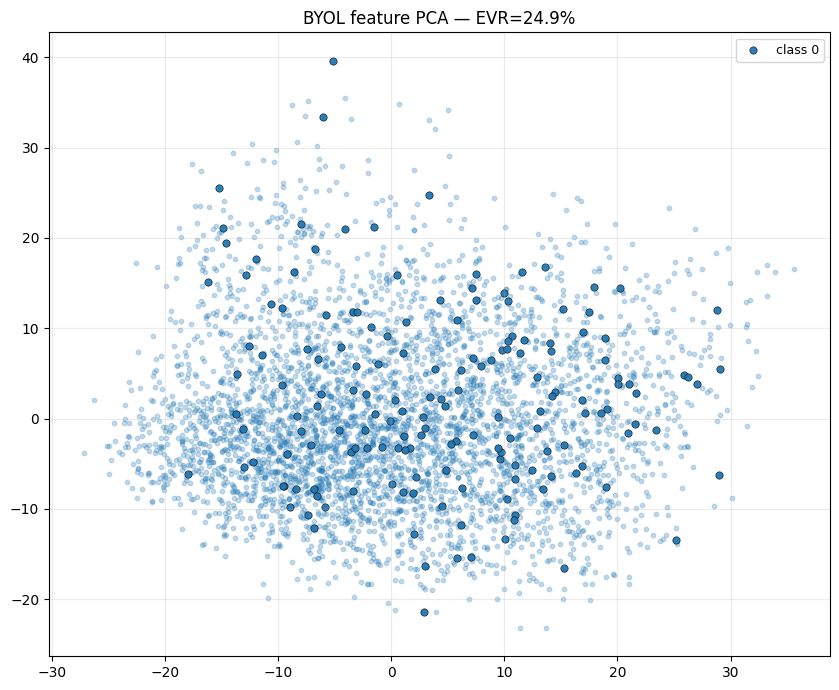

➤ Running t-SNE …


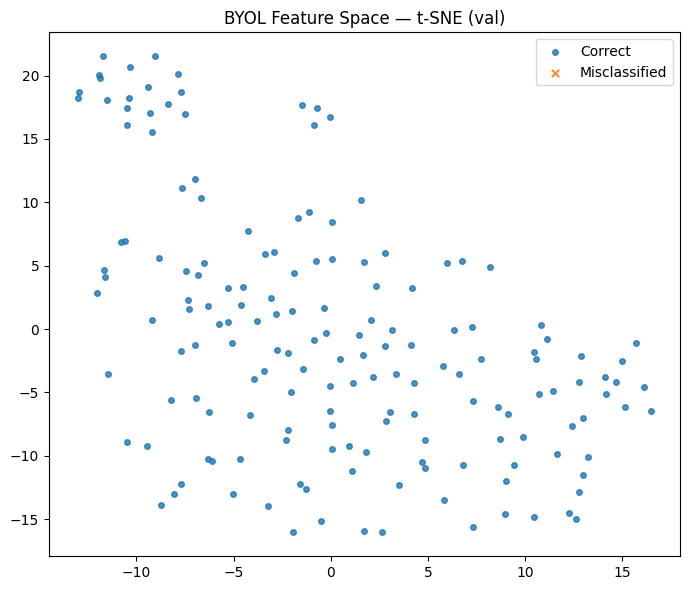

➤ Running UMAP …


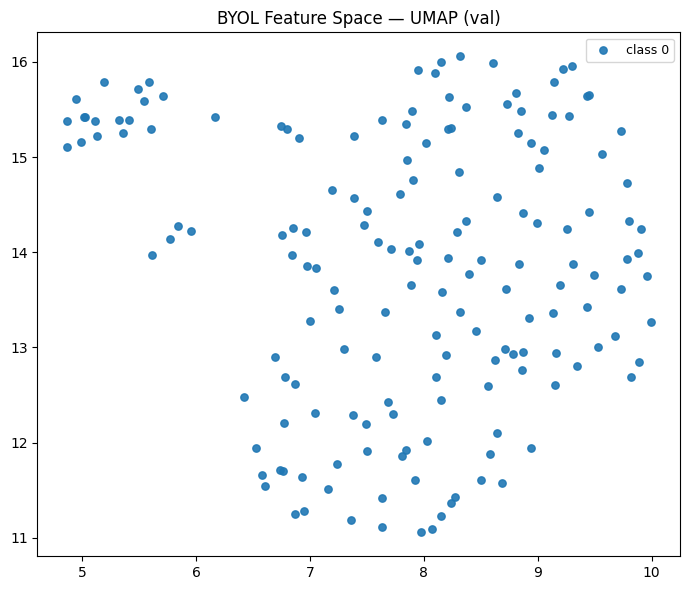


✓ All visualizations saved in: /kaggle/working/SSL-BYOL/plots


In [13]:
PLOTS  = WORK / "plots"
PLOTS.mkdir(parents=True, exist_ok=True)

# --- HELPERS ---
def imread_rgb(path: Path):
    return Image.open(path).convert("RGB")

def yolo_label_for_image(label_file: Path):
    if not label_file.exists():
        return None
    ids=[]
    with open(label_file) as f:
        for line in f:
            parts=line.strip().split()
            if parts:
                try: ids.append(int(parts[0]))
                except: pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None:
            continue
        xs.append(img_path); ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

def get_detect_module(model_module):
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])    # [P3,P4,P5]
        return None
    def close(self): self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

# --- DATA ---
train_X, train_y = list_images_and_labels(WORK/"train")
val_X,   val_y   = list_images_and_labels(WORK/"valid")
assert len(train_X) and len(val_X), "No labeled images found."

# --- FEATURE EXTRACTION ---
print("➤ Loading BYOL feature extractor …")
feat_model = YOLO("yolo11s.pt").model.to(device)
_ = feat_model.load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
feat_hook  = DetectInputHook(get_detect_module(feat_model))
feat_model.eval()

base_tfm = transforms.Compose([transforms.Resize((160,160)), transforms.ToTensor()])

class ImgDataset(Dataset):
    def __init__(self, paths, tfm): self.paths=paths; self.tfm=tfm
    def __len__(self): return len(self.paths)
    def __getitem__(self,i): return self.tfm(imread_rgb(self.paths[i]))

def extract_feats(paths, bs=64, desc="Extract"):
    ds  = ImgDataset(paths, base_tfm)
    dl  = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
    feats=[]
    for xb in tqdm(dl, total=len(dl), desc=desc, leave=False):
        xb = xb.to(device, non_blocking=True)
        with torch.no_grad():
            _ = feat_model(xb)
            h  = global_pool_concat(feat_hook.feats)
        feats.append(h.detach().cpu().numpy())
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,1))

print("➤ Extracting features …")
train_F = extract_feats(train_X, bs=64, desc="Extract train")
val_F   = extract_feats(val_X,   bs=64, desc="Extract val")

feat_hook.close()
del feat_model
gc.collect()
if device=="cuda": torch.cuda.empty_cache()

# --- k-NN CLASSIFIER ---
print("\nBYOL k-NN evaluation …")
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(train_F, train_y)
val_pred = knn.predict(val_F)
acc = accuracy_score(val_y, val_pred)
print(f"k-NN accuracy (val): {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(val_y, val_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("BYOL features + k-NN (val) — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(PLOTS/"knn_confusion_matrix.png", dpi=160)
plt.show()

# --- STANDARDIZE ---
scaler = StandardScaler(with_mean=True, with_std=True)
train_Fs = scaler.fit_transform(train_F)
val_Fs   = scaler.transform(val_F)

# --- PCA ---
print("➤ Running PCA …")
pca = PCA(n_components=2, random_state=42)
train_P = pca.fit_transform(train_Fs)
val_P   = pca.transform(val_Fs)
evr = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {evr*100:.2f}%")

plt.figure(figsize=(8.5,7))
classes = np.unique(np.concatenate([train_y, val_y]))
cmap = plt.get_cmap("tab10")
for c in classes:
    idx = np.where(train_y==c)[0]
    if len(idx):
        plt.scatter(train_P[idx,0], train_P[idx,1], s=10, alpha=0.25, color=cmap(int(c)%10))
for c in classes:
    idx = np.where(val_y==c)[0]
    if len(idx):
        plt.scatter(val_P[idx,0], val_P[idx,1], s=28, alpha=0.95, edgecolors='k', linewidths=0.4,
                    color=cmap(int(c)%10), marker='o', label=f"class {c}")
plt.title(f"BYOL feature PCA — EVR={evr*100:.1f}%")
plt.legend(fontsize=9, ncol=2, frameon=True)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(PLOTS/"pca_train_val.png", dpi=160)
plt.show()

# --- t-SNE ---
if len(val_F) > 10:
    print("➤ Running t-SNE …")
    perplex = min(30, max(5, len(val_F)//10))
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                perplexity=perplex, n_iter=1000, random_state=42)
    Z_tsne = tsne.fit_transform(val_Fs)
    mistakes = (val_pred != val_y)
    plt.figure(figsize=(7,6))
    plt.scatter(Z_tsne[~mistakes,0], Z_tsne[~mistakes,1], s=16, label="Correct", alpha=0.8)
    plt.scatter(Z_tsne[mistakes,0],   Z_tsne[mistakes,1],   s=28, marker="x", label="Misclassified", alpha=0.9)
    plt.title("BYOL Feature Space — t-SNE (val)")
    plt.legend(); plt.tight_layout()
    plt.savefig(PLOTS/"tsne_val.png", dpi=160)
    plt.show()

# --- UMAP ---
print("➤ Running UMAP …")
umap_model = umap.UMAP(n_components=2, random_state=42)
Z_umap = umap_model.fit_transform(val_Fs)
plt.figure(figsize=(7,6))
for c in classes:
    idx = np.where(val_y==c)[0]
    plt.scatter(Z_umap[idx,0], Z_umap[idx,1], s=28, alpha=0.9, label=f"class {c}")
plt.title("BYOL Feature Space — UMAP (val)")
plt.legend(fontsize=9, ncol=2, frameon=True)
plt.tight_layout()
plt.savefig(PLOTS/"umap_val.png", dpi=160)
plt.show()

print("\n✓ All visualizations saved in:", PLOTS)

## 10. Load the backbone model and Fine-Tune with YOLOv11s Type detection Model

In [14]:
print("\n Fine-tuning YOLOv11-s (1 epoch) …")
det = YOLO(MODEL)  # nano to match SSL shapes
# load into all-but-Detect
sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data=str(DATA),
    epochs=50,                # ← set to 1 epoch
    imgsz=640,
    batch=8,
    project=str(WORK),
    save = True,
    name="byol_yolo11s",
    device=0 if device=="cuda" else None,
    verbose=True
)



 Fine-tuning YOLOv11-s (1 epoch) …
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/SSL-BYOL/data_Sunflower.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=byol_yolo11s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2279.9±429.7 MB/s, size: 98.7 KB)


train: Scanning /kaggle/working/SSL-BYOL/train/labels... 3957 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3957/3957 [00:03<00:00, 1147.49it/s]


train: New cache created: /kaggle/working/SSL-BYOL/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 737.6±580.8 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/SSL-BYOL/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 604.81it/s]

val: New cache created: /kaggle/working/SSL-BYOL/valid/labels.cache


Plotting labels to /kaggle/working/SSL-BYOL/byol_yolo11s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/SSL-BYOL/byol_yolo11s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      0.76G      1.624      0.978      1.118        337        640: 100%|██████████| 495/495 [01:44<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

                   all        165      13823      0.796      0.786       0.85      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.95G      1.488     0.8094      1.036        843        640: 100%|██████████| 495/495 [01:30<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823      0.839      0.812      0.892       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.99G      1.462     0.7813      1.022        774        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        165      13823       0.83      0.791      0.875      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.03G      1.436     0.7661      1.012        486        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.844       0.81      0.892      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.07G      1.409     0.7433      1.005        492        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        165      13823      0.846      0.805      0.889      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.09G      1.391       0.73     0.9959        617        640: 100%|██████████| 495/495 [01:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.03it/s]

                   all        165      13823      0.833      0.823      0.896      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.15G      1.379      0.724     0.9931        859        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        165      13823      0.849      0.818      0.899      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.19G      1.368      0.712     0.9859        658        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.04it/s]

                   all        165      13823      0.842      0.826      0.898      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.23G      1.357     0.7054     0.9819        648        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823      0.851      0.817      0.898      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.27G      1.343     0.6982     0.9763        332        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        165      13823      0.857      0.825      0.905      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.31G      1.345     0.6942     0.9775        282        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.10it/s]

                   all        165      13823       0.86      0.811        0.9      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.35G      1.325     0.6828     0.9719        473        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.06it/s]

                   all        165      13823      0.854      0.823      0.905       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.39G       1.32     0.6782     0.9704        578        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.858      0.818      0.904      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.41G      1.322     0.6788     0.9705        414        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        165      13823       0.85      0.827      0.904      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.47G      1.317     0.6763     0.9691        629        640: 100%|██████████| 495/495 [01:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.851       0.83      0.905      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.51G      1.305     0.6671     0.9674        509        640: 100%|██████████| 495/495 [01:29<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.21it/s]

                   all        165      13823      0.847      0.831      0.903      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.55G      1.311      0.667     0.9668        474        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]

                   all        165      13823      0.846      0.831      0.904      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.17G      1.298     0.6616     0.9635        825        640: 100%|██████████| 495/495 [01:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.11it/s]

                   all        165      13823       0.85      0.833      0.906      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.21G      1.295     0.6575     0.9625        656        640: 100%|██████████| 495/495 [01:30<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.852      0.834       0.91      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.26G      1.291     0.6544     0.9613        594        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.851      0.828      0.905       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G       1.28     0.6476     0.9593        570        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.857      0.831      0.908      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.32G      1.278     0.6482     0.9568        535        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]

                   all        165      13823      0.856      0.832      0.911       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.37G      1.279     0.6464     0.9582        301        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823      0.861      0.828      0.911      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.05G      1.273     0.6445     0.9572        467        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.856      0.832      0.909      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.05G      1.262     0.6353     0.9515        633        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        165      13823      0.854      0.836      0.909      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.05G      1.267     0.6373     0.9525        264        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.856      0.833      0.908       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.05G       1.26     0.6312     0.9531        462        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.13it/s]

                   all        165      13823      0.862      0.839      0.915      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.07G      1.255     0.6302     0.9512        579        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823      0.864      0.833      0.911      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.11G      1.248     0.6255     0.9481        670        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823       0.86      0.833      0.911      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.13G      1.248     0.6261     0.9475        230        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]

                   all        165      13823      0.861      0.839      0.915      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.73G      1.246     0.6221      0.947        455        640: 100%|██████████| 495/495 [01:29<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.865      0.833      0.914       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.77G      1.245     0.6201     0.9467        407        640: 100%|██████████| 495/495 [01:29<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.19it/s]

                   all        165      13823      0.858      0.835      0.912      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.81G      1.243     0.6202     0.9465        322        640: 100%|██████████| 495/495 [01:30<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.05it/s]

                   all        165      13823      0.858       0.84      0.915      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.85G      1.231     0.6125     0.9418        276        640: 100%|██████████| 495/495 [01:30<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        165      13823       0.86      0.841      0.916      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.89G      1.238     0.6148     0.9443        729        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.08it/s]

                   all        165      13823       0.86      0.834      0.914      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.93G      1.228     0.6088     0.9419        582        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.855       0.84      0.913      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.97G      1.223     0.6042     0.9392        490        640: 100%|██████████| 495/495 [01:30<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

                   all        165      13823       0.86       0.84      0.916      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.99G       1.22     0.6048     0.9401        586        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

                   all        165      13823      0.854      0.844      0.915      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.05G      1.218     0.6003     0.9385        421        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        165      13823      0.862      0.842      0.917      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.09G      1.212     0.5985     0.9381        483        640: 100%|██████████| 495/495 [01:30<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.17it/s]

                   all        165      13823      0.859      0.845      0.918      0.589


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.13G      1.217     0.5924     0.9473        279        640: 100%|██████████| 495/495 [01:24<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]

                   all        165      13823      0.856       0.84      0.914      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.17G      1.203     0.5848     0.9401        263        640: 100%|██████████| 495/495 [01:23<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.23it/s]

                   all        165      13823      0.863      0.837      0.915      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.21G        1.2     0.5813     0.9403        389        640: 100%|██████████| 495/495 [01:24<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]

                   all        165      13823      0.866      0.839      0.917      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.25G      1.192     0.5771     0.9382        476        640: 100%|██████████| 495/495 [01:23<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.12it/s]

                   all        165      13823      0.862       0.84      0.917      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.29G      1.186     0.5741      0.938        509        640: 100%|██████████| 495/495 [01:23<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.14it/s]

                   all        165      13823      0.864      0.839      0.916      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.31G      1.182     0.5706     0.9368        336        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]

                   all        165      13823      0.861      0.842      0.917      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.37G      1.181     0.5684     0.9363        349        640: 100%|██████████| 495/495 [01:23<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.20it/s]

                   all        165      13823      0.866       0.84      0.917      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.41G       1.17     0.5636     0.9312        383        640: 100%|██████████| 495/495 [01:23<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

                   all        165      13823      0.865      0.842      0.918      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.45G      1.167     0.5602     0.9309        374        640: 100%|██████████| 495/495 [01:23<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.18it/s]

                   all        165      13823      0.864      0.841      0.917       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.48G      1.163      0.558     0.9295        179        640: 100%|██████████| 495/495 [01:24<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.15it/s]

                   all        165      13823      0.862      0.843      0.918      0.592



50 epochs completed in 1.275 hours.
Optimizer stripped from /kaggle/working/SSL-BYOL/byol_yolo11s/weights/last.pt, 19.2MB
Optimizer stripped from /kaggle/working/SSL-BYOL/byol_yolo11s/weights/best.pt, 19.2MB

Validating /kaggle/working/SSL-BYOL/byol_yolo11s/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:00<00:02,  3.96it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


                   all        165      13823      0.862      0.828      0.904      0.581
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 22.0ms postprocess per image
Results saved to /kaggle/working/SSL-BYOL/byol_yolo11s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dcc7456f150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## 11. Loss Curve Visualization

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


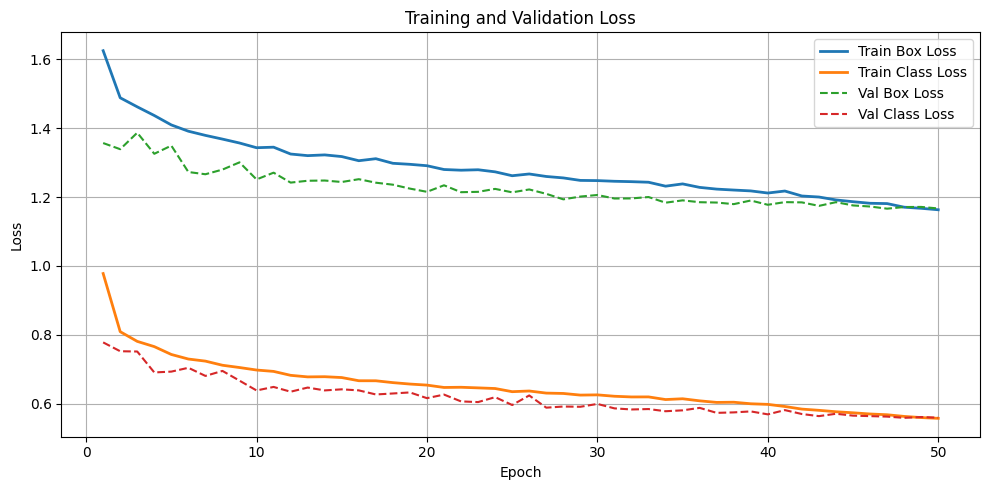

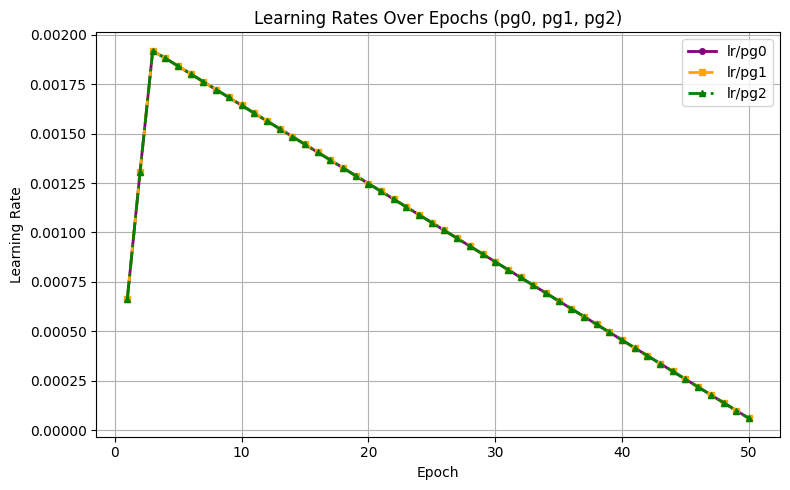

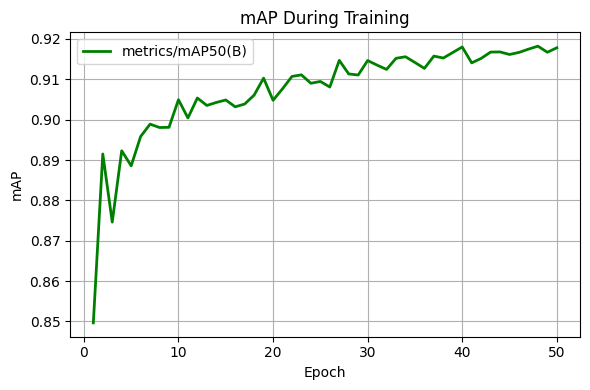

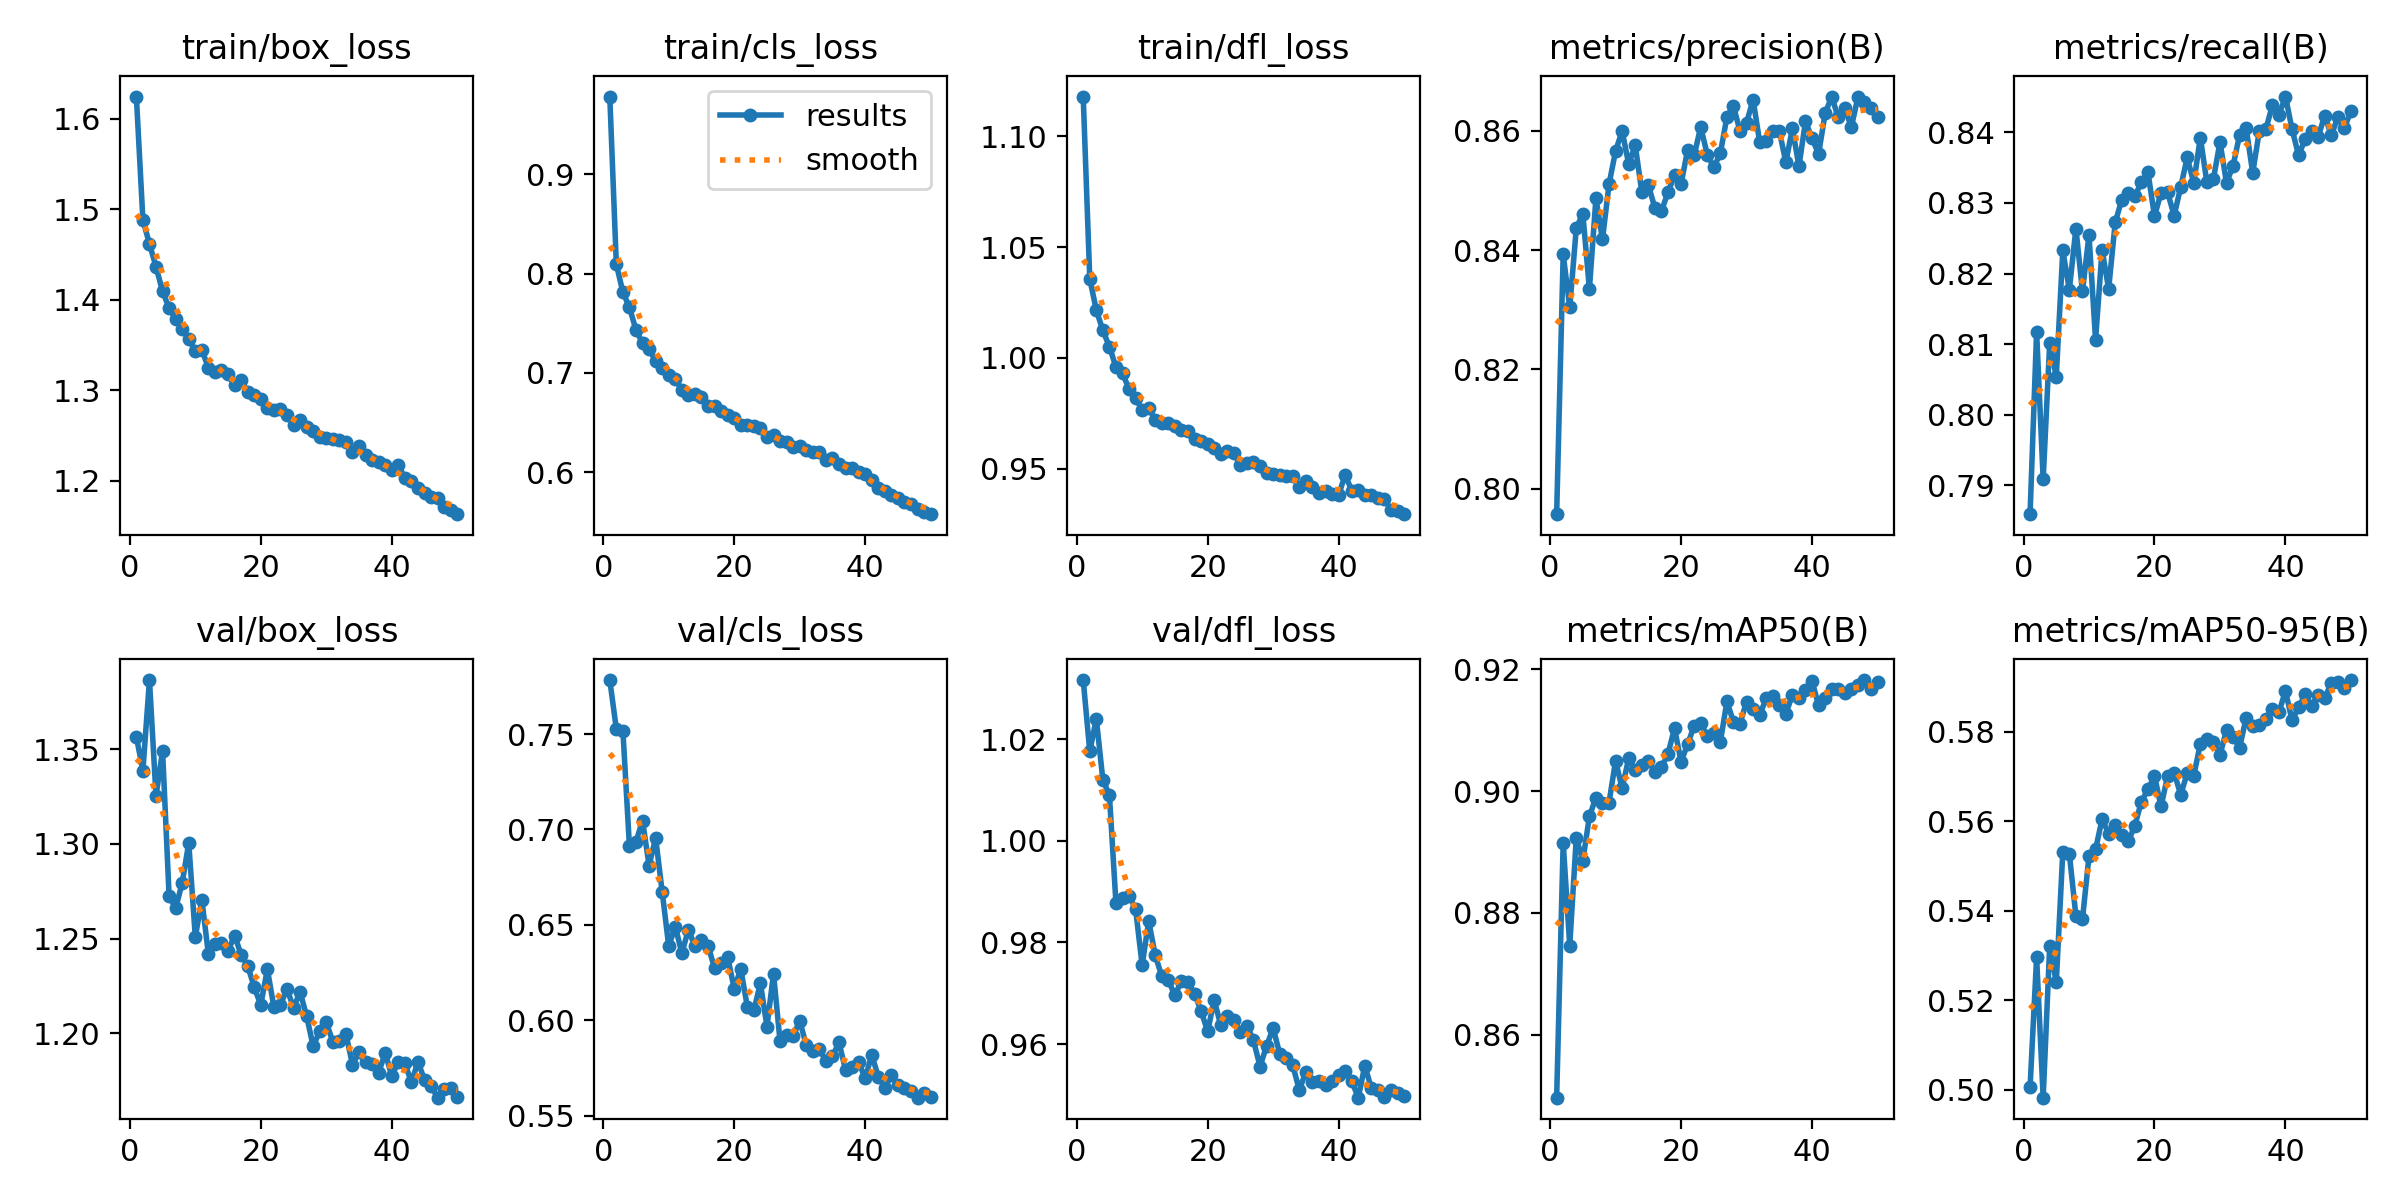

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "byol_yolo11s" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "byol_yolo11s" / "results.png"
img = Image.open(results_img)
display(img)

## 12. Evaluation and Visualization


 Evaluating …
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2210.9±499.0 MB/s, size: 101.9 KB)


val: Scanning /kaggle/working/SSL-BYOL/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:08<00:00,  4.81it/s]


                   all        165      13823      0.861      0.845      0.918      0.592
Speed: 0.9ms preprocess, 44.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.8613
Recall (mR)      : 0.8450
mAP@0.50         : 0.9182
mAP@0.50:0.95    : 0.5921
Visualising: MVI_9838-MP4_frame32_jpg.rf.4d7ed28f65a2e4ae39fb73ccda06c767.jpg
Visualising: MVI_9972-MP4_frame9_jpg.rf.b6d2f36177ee38db6012c1a0ac0402e6.jpg
Visualising: MVI_9971-MP4_frame4_jpg.rf.063564ab8d57d2ca8ac8ca1645b98351.jpg
Visualising: 20240206_132004-mp4_frame43_jpg.rf.d7420804b6e719774eaf3ab235b57382.jpg


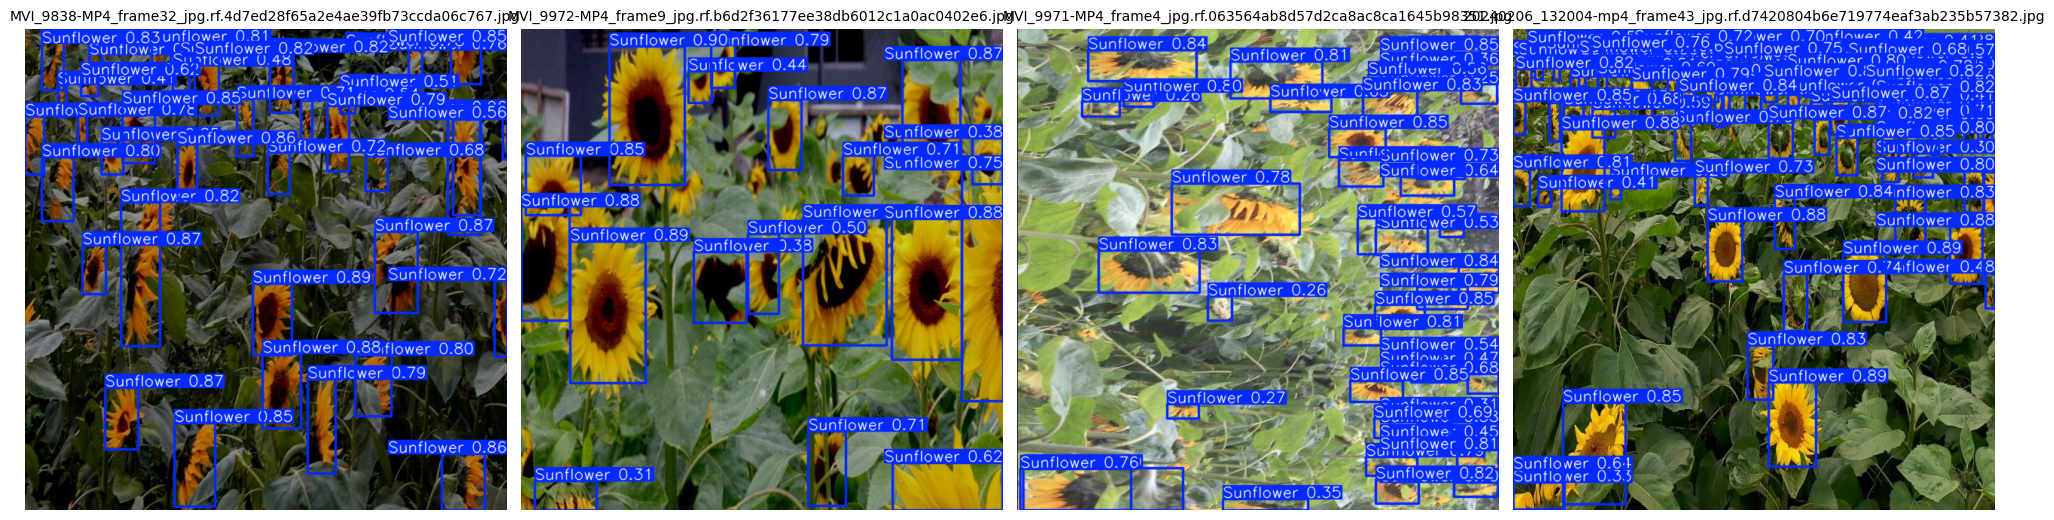

In [16]:

print("\n Evaluating …")
best_pt = WORK / "byol_yolo11s"/"weights"/"best.pt"
model   = YOLO(str(best_pt))
results = model.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else None)

try:
    mp,mr,map50,map5095 = results.mean_results()
    print("\nValidation metrics")
    print(f"Precision (mP)   : {mp:.4f}")
    print(f"Recall (mR)      : {mr:.4f}")
    print(f"mAP@0.50         : {map50:.4f}")
    print(f"mAP@0.50:0.95    : {map5095:.4f}")
except Exception:
    print("Ultralytics API changed; raw results follows:")
    print(results)

import random

# pick from test or valid images
cands = list((WORK/"test"/"images").glob("*.*")) or list((WORK/"valid"/"images").glob("*.*"))

if cands:
    imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    axes = axes.flatten()

    for ax, img_path in zip(axes, imgs):
        print("Visualising:", img_path.name)
        pred = model.predict(
            source=str(img_path),
            imgsz=640,
            conf=0.25,
            device=0 if device == "cuda" else None,
            verbose=False
        )[0]
        ax.imshow(pred.plot()[:,:,::-1])
        ax.axis("off")
        ax.set_title(img_path.name, fontsize=10)

    # hide unused axes if <4 images
    for ax in axes[len(imgs):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("No images found for visualization.")

